In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, structure_optimization_lib, \
                    data_utils, cavi_lib, \
                    fast_structure_lib, plotting_utils

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
# data_file = '../../../../fastStructure/test/testdata.npz'
data_file = '../../../../fastStructure/hgdp_data/huang2011_plink_files/' + \
            'phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data = np.load(data_file)
g_obs = np.array(data['g_obs'])

g_obs = np.array(data['g_obs'])
g_obs_raw = np.array(data['g_obs_raw'])

# just checking ... 
which_missing = (g_obs_raw == 3)
(g_obs.argmax(-1) == g_obs_raw)[~which_missing].all()
(g_obs[which_missing] == 0).all()

DeviceArray(True, dtype=bool)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load fastStructure fit

In [5]:
# filename = '../../../../fastStructure/fits/test/testoutput_simple.3'
filename = '../../../../fastStructure/fits/huang2011/phased_regions1to26.5'

In [6]:
vb_params_dict, vb_params_paragami = fast_structure_lib.load_fs_to_vb_params(filename)
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2810, 5, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (1107, 4, 2) (lb=0.0, ub=inf)


In [7]:
e_ind_admix, e_pop_freq = plotting_utils.get_vb_expectations(vb_params_dict)

In [8]:
fs_k = e_pop_freq.shape[1]

### Check against fast-structure saved means

In [9]:
fs_e_ind_admix, _, fs_e_pop_freq, _ = \
    fast_structure_lib.load_fs_means_vars(filename)

In [10]:
np.abs(e_pop_freq - fs_e_pop_freq).max()

DeviceArray(5.00816246e-07, dtype=float64)

In [11]:
np.abs(e_ind_admix - fs_e_ind_admix).max()

DeviceArray(4.99900853e-07, dtype=float64)

In [12]:
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

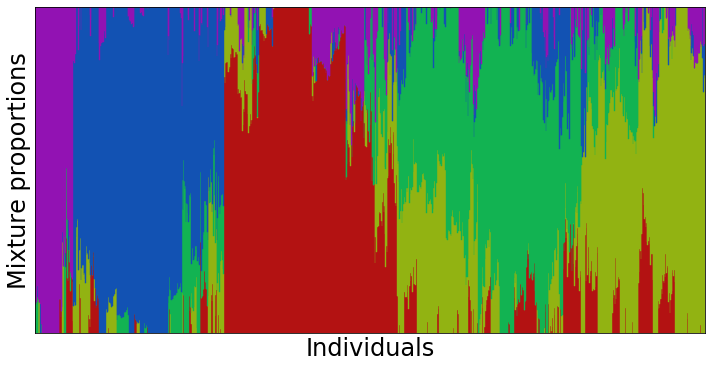

In [13]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))

# _ = plotting_utils.plot_admixture(e_ind_admix[indx], axarr)
plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 5)
axarr.set_xlabel('Individuals', fontsize = 24)
axarr.set_ylabel('Mixture proportions', fontsize = 24);

# Check against my fit

In [14]:
vb_params_dict, vb_params_paragami, meta_data = \
    paragami.load_folded('../fits/fits_20201121/huang2011_fit_alpha3.0.npz')

gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

e_ind_admix_bnp, e_pop_freq_bnp = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)

In [15]:
# f, axarr = plt.subplots(1, 1, figsize=(12, 6))

# _ = plotting_utils.plot_admixture(e_ind_admix_bnp[indx], axarr)
# axarr.set_xlabel('Individuals', fontsize = 24)
# axarr.set_ylabel('Mixture proportions', fontsize = 24);

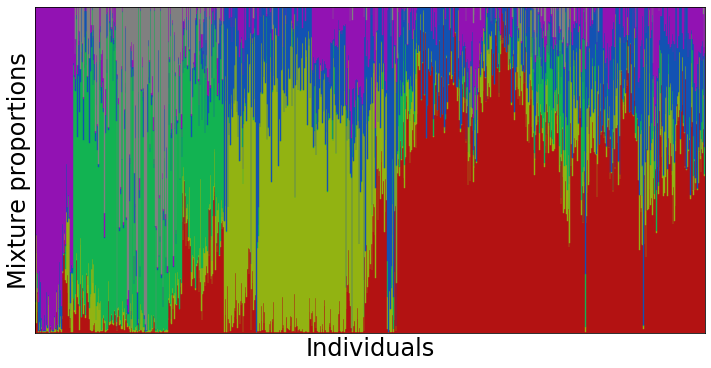

In [16]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))

plotting_utils.plot_top_clusters(e_ind_admix_bnp[indx], axarr, 5)
axarr.set_xlabel('Individuals', fontsize = 24)
axarr.set_ylabel('Mixture proportions', fontsize = 24);